# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [3, 10]
        pool_kernel = [1, 1]
        fc_unit = [64]
        drop_out = [0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        fc_input_size = int(np.prod(img_size) * conv_channel[1])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.bn2(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x


In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = True # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = None # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = N_inputtime # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 5e-4,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 50,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (14, 129, 170)
Single output data size: (4,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
summary(model, DataSize[0])


CTKNet(
  (conv1): Conv2d(14, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=93810, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 127, 168]             635
         MaxPool2d-2          [-1, 5, 127, 168]               0
            Conv2d-3          [-1, 5, 118, 159]           2,505
         MaxPool2d-4          [-1, 5, 118, 159]               0
            Linear-5                   [-1, 64]       6,003,904
           Dropout-6                   [-1, 64]               0
            Linear-7 

/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



1/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.06328072249889374 0.08634448162693945 0.1094163917892036
Train/Val/TEST Accuracy: 79.71014492753623 72.22222222222223 47.61904761904762
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.027777369879186154 0.0910043211446868 0.0834769228295911
Train/Val/TEST Accuracy: 78.26086956521739 55.55555555555556 57.142857142857146
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.02410228122025728 0.08045238194366296 0.07772406751090395
Train/Val/TEST Accuracy: 88.40579710144928 66.66666666666667 61.904761904761905
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.01775848902761936 0.09157713231009741 0.07665075714300786
Train/Val/TEST Accuracy: 86.95652173913044 66.66666666666667 66.66666666666667
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.01337524801492691 0.07473848703213865 0.06989621112699665
Train/Val/TEST Accuracy: 94.20289855072464 77.77777777777777 66.66666666666667
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.012111460231244564 0.06784645198947853 0.0720068185723253

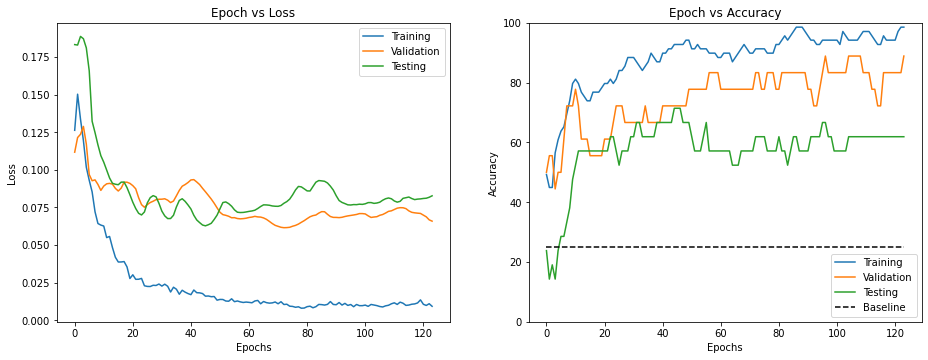

Train/Val/Test Final MSE: [0.010499020852148534, 0.061547394583208695, 0.07778006228840068]
Train/Val/Test Maximum Accuracy: [91.30434782608695, 83.33333333333333, 61.904761904761905]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.08213095963001252 0.10808348081385095 0.14662776643499023
Train/Val/TEST Accuracy: 71.01449275362319 50.0 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.03494895882904529 0.09832308519010742 0.11718488963586944
Train/Val/TEST Accuracy: 89.85507246376811 44.44444444444444 38.095238095238095
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.02277757190167904 0.10451338103868896 0.09739336899171273
Train/Val/TEST Accuracy: 95.65217391304348 55.55555555555556 47.61904761904762
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0166113780811429 0.11559869307610723 0.09917291559811149
Train/Val/TEST Accuracy: 98.55072463768116 50.0 52.38095238095238
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.014502669498324395 0.10533123202104536 0.09728579255863137
Train/Val/TEST Accuracy: 100.0 50.0 52.38095238095238
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.013678897731006145 0.10571946505094981 0.10684969072185811
Train/Val/TEST Accuracy: 94.20289855072464 50.0 

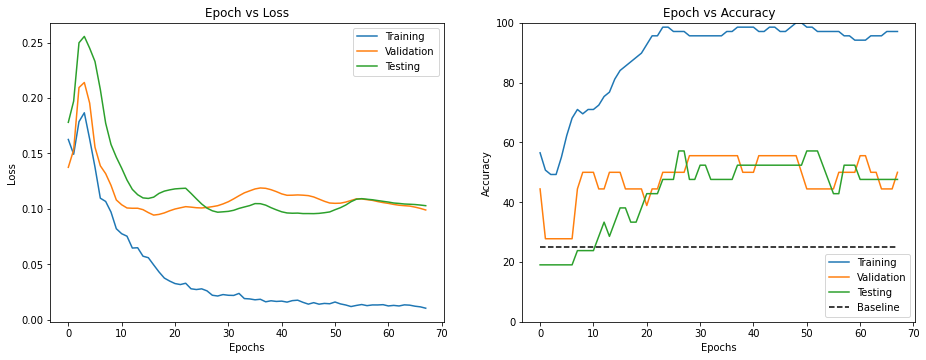

Train/Val/Test Final MSE: [0.04952614158391953, 0.09443439737272759, 0.1106192500862692]
Train/Val/Test Maximum Accuracy: [85.5072463768116, 44.44444444444444, 38.095238095238095]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.04983159825205803 0.09923344105482101 0.1405548495462253
Train/Val/TEST Accuracy: 90.0 58.8235294117647 47.61904761904762
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.028707972913980483 0.09965531700564657 0.12664213989462172
Train/Val/TEST Accuracy: 90.0 58.8235294117647 38.095238095238095
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.02111441157758236 0.06955244918079938 0.10508675285659376
Train/Val/TEST Accuracy: 92.85714285714286 70.58823529411765 47.61904761904762
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.01349609810858965 0.0801124382928452 0.11081856768578291
Train/Val/TEST Accuracy: 92.85714285714286 58.8235294117647 52.38095238095238
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.01233639745041728 0.07777774968074963 0.11325430847881805
Train/Val/TEST Accuracy: 94.28571428571429 64.70588235294117 42.857142857142854
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.011153683625161647 0.0814110165092108 0.10512448142149619
Train/Val/TEST Accuracy: 91

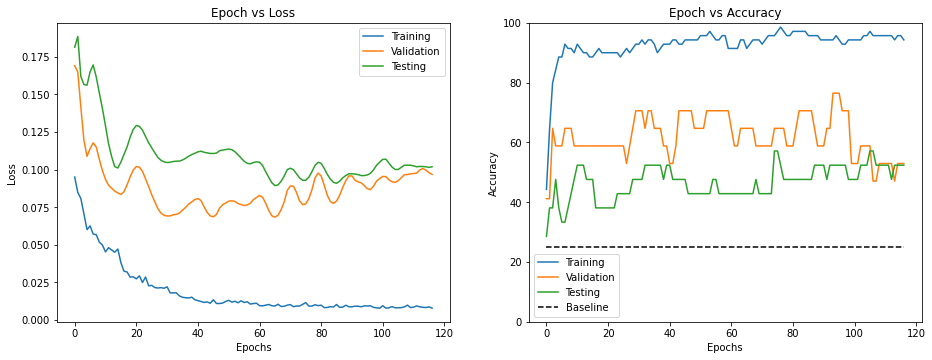

Train/Val/Test Final MSE: [0.00931411338970065, 0.06832246183801223, 0.08932495773548171]
Train/Val/Test Maximum Accuracy: [91.42857142857143, 64.70588235294117, 42.857142857142854]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.07070412784814835 0.10877557438524331 0.11204185112867326
Train/Val/TEST Accuracy: 82.85714285714286 52.94117647058823 23.80952380952381
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.027818942442536354 0.1094940495403374 0.09843727436271452
Train/Val/TEST Accuracy: 87.14285714285714 47.05882352941177 42.857142857142854
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.01971747223287821 0.10711138142163262 0.08671498529258229
Train/Val/TEST Accuracy: 95.71428571428571 58.8235294117647 47.61904761904762
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.01828769538551569 0.09469669473850552 0.08591500459061492
Train/Val/TEST Accuracy: 91.42857142857143 35.294117647058826 47.61904761904762
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.01419041994959116 0.08501385409823235 0.08391174953430891
Train/Val/TEST Accuracy: 92.85714285714286 52.94117647058823 57.142857142857146
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.012938044965267181 0.07774590505013133 0.07998694630251

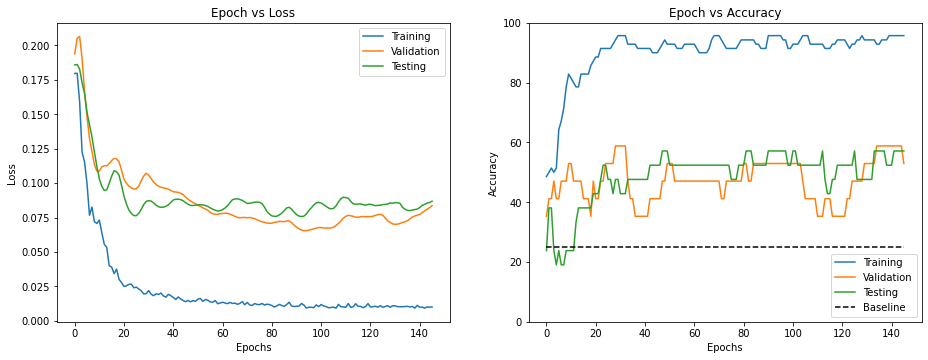

Train/Val/Test Final MSE: [0.009299660753458738, 0.06543518471367218, 0.07763881382665463]
Train/Val/Test Maximum Accuracy: [95.71428571428571, 52.94117647058823, 57.142857142857146]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.06546418592333794 0.1234999798676547 0.10971690412788164
Train/Val/TEST Accuracy: 72.85714285714286 23.529411764705884 42.857142857142854
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.036644648388028146 0.09590582944014493 0.09442752069749293
Train/Val/TEST Accuracy: 78.57142857142857 52.94117647058823 47.61904761904762
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.02295391783118248 0.08916170917013112 0.08290687490565081
Train/Val/TEST Accuracy: 92.85714285714286 64.70588235294117 47.61904761904762
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.015489904582500458 0.06944300782154589 0.10182887883413405
Train/Val/TEST Accuracy: 88.57142857142857 76.47058823529412 47.61904761904762
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.012887216545641423 0.08791697162258275 0.10042740236080828
Train/Val/TEST Accuracy: 95.71428571428571 58.8235294117647 57.142857142857146
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.012299813143908978 0.08110734757364672 0.101071209957

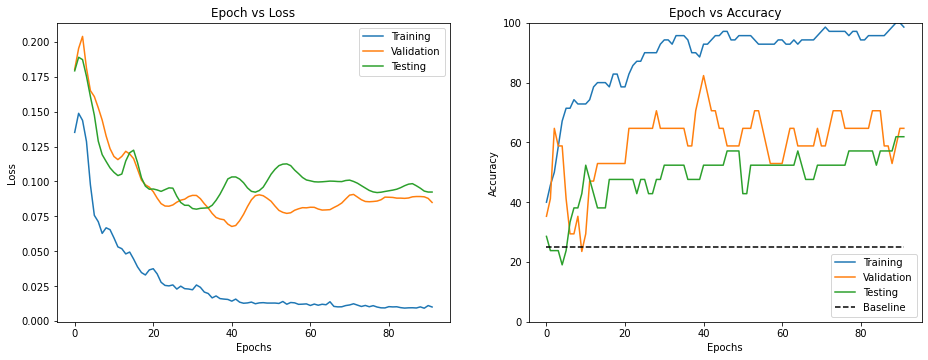

Train/Val/Test Final MSE: [0.01426982618868351, 0.06776385297587909, 0.10322944442963317]
Train/Val/Test Maximum Accuracy: [92.85714285714286, 82.3529411764706, 52.38095238095238]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.018581752553582194, 0.07150065829669996, 0.09171850567328789]
Train/Val/Test Average Accuracy: [91.36231884057972, 65.55555555555556, 50.476190476190474]


## Single prediction results

In [11]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output, CerealTimeKillersLabels)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target, CerealTimeKillersLabels)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', tlabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [5.1886686e-06 6.3091379e-01 2.1761049e-02 8.2874507e-02] with label  [1]
Target Example: [0.         1.         0.11111111 0.        ] with label  [1]
------- MSE: 0.03776906058192253  Accuracy: 100.0 %-------

Batch 2  ( Size 1 ):
Output Example: [9.7474867e-01 3.6347794e-04 1.6786898e-02 1.8156748e-02] with label  [0]
Target Example: [1. 0. 1. 0.] with label  [0, 2]
------- MSE: 0.2419188767671585  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.33648115 0.19280274 0.46344703 0.4939297 ] with label  [3]
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  [0]
------- MSE: 0.13351790606975555  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [1.7151398e-04 5.2965211e-04 3.8205925e-01 1.9887339e-01] with label  [2]
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  [3]
------- MSE: 0.08475562930107117  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.01363769 0